## PyTorch Experiment tracking.

Helps track the experiments and figure out what does not work.

In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torchinfo import summary

from going_modular import data_setup, engine

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu126
0.21.0+cu126


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [4]:
set_seeds()

## Get data

Want to get pizza, steak and sushi images.

So we can run experiment and track the best model.

In [5]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str,
                 destination: str,
                 removed_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination."""

    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path/destination

    #If image folder doesn't exist, create it
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory already exists")
    else:
        print(f"[INFO] could not find {image_path} , creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download the target data
        target_file = Path(source).name
        with open(data_path/target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        #Unzip target file
        with zipfile.ZipFile(data_path/target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping")
            zip_ref.extractall(image_path)

        # Remove the .zip file
        if removed_source:
            os.remove(data_path/target_file)

    return image_path

In [6]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip",
                          destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory already exists


WindowsPath('data/pizza_steak_sushi')

## Create datasets and dataloaders


### Create data loaders with manual transforms

In [7]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [8]:
# Setup directores
train_dir = image_path / "train"
test_dir = image_path / "test"


train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [9]:
# Create transform pipeline manually
from torchvision import transforms

# Setup ImageNet normalization levels
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])


manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

print(f"Manual tranforms {manual_transforms}")

# Cretae DataLoaders
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=manual_transforms,
                                                                              batch_size=32)

train_dataloader, test_dataloader, class_names

Manual tranforms Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x1b2e425b1f0>,
 ['pizza', 'steak', 'sushi'])

## Create Dataloaders using automatic transforms

In [10]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup the pretrained weights
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get the tranforms from weights
automatic_tranforms = weights.transforms()
print(automatic_tranforms)


# Create data loaders
train_dataloader, test_dataloaders, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=automatic_tranforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x1b2e425b4c0>,
 ['pizza', 'steak', 'sushi'])

# Get a pretrained model and freeze the base layers

In [11]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # DEFAULT is best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
# model

In [13]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [14]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [15]:
# Print a summary with torchinfo
from torchinfo import summary

summary(model=model,
       input_size=(1, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### Freezing the base model and changing the output layer to suit our needs

We freeze the base layers and train the output layers.

In [16]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
    # print(param)
    param.requires_grad = False

In [17]:
len(class_names)

3

In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Update the classifier head of model to suit our problem
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
             out_features=len(class_names))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [19]:
summary(model=model,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train a single model and track results

In [20]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

To track experiment we are going to use tensorboard

In [21]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [22]:
import torch
from typing import Dict, List, Tuple
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.
    
    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.
    
    Calculates, prints and stores evaluation metrics throughout.
    
    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    
    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
    }
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        ## New: Experiment tracking
        writer.add_scalars(main_tag="Loss",
                        tag_scalar_dict={"train_loss": train_loss,
                                        "test_loss": test_loss},
                         global_step=epoch)
        
        writer.add_scalars(main_tag="Accuracy",
                        tag_scalar_dict={"train_acc": train_acc,
                                        "test_acc": test_acc},
                        global_step=epoch)
        
        writer.add_graph(model=model,
                      input_to_model=torch.randn(32, 3, 224, 224).to(device))

    ## Close the writer
    writer.close()

    
    # Return the filled results at the end of the epochs
    return results

In [23]:
# Train the model
# Using the modified train function
set_seeds()
results = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=5,
               device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0974 | train_acc: 0.3789 | test_loss: 0.9341 | test_acc: 0.5139
Epoch: 2 | train_loss: 0.9023 | train_acc: 0.6484 | test_loss: 0.8253 | test_acc: 0.7361
Epoch: 3 | train_loss: 0.8136 | train_acc: 0.7266 | test_loss: 0.7107 | test_acc: 0.8993
Epoch: 4 | train_loss: 0.6772 | train_acc: 0.8477 | test_loss: 0.6992 | test_acc: 0.8056
Epoch: 5 | train_loss: 0.7112 | train_acc: 0.7266 | test_loss: 0.7116 | test_acc: 0.6910


## View our models results with tensorboard

## View our models results with tensorboard

In [24]:
%load_ext tensorboard
%tensorboard --logdir runs

## Create a function to prepare a `SummaryWriter()` instance

How about saving different experiments to different folders?

In [25]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                 model_name: str,
                 extra: str = None):
    """Create a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to a specific directory."""
    from datetime import datetime
    import os

    # Get timestamp of current dat in reverse order
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        # create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    return SummaryWriter(log_dir=log_dir)

In [26]:
example_writer = create_writer(experiment_name="data_10_percent",
                              model_name="effnetb0",
                              extra="5_epochs")
example_writer

## Update the train function to include the writer parameter

In [27]:
import torch
from typing import Dict, List, Tuple
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
         writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.
    
    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.
    
    Calculates, prints and stores evaluation metrics throughout.
    
    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    
    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
    }
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        ## New: Experiment tracking
        if writer:
            writer.add_scalars(main_tag="Loss",
                            tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                             global_step=epoch)
            
            writer.add_scalars(main_tag="Accuracy",
                            tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                            global_step=epoch)
            
            writer.add_graph(model=model,
                          input_to_model=torch.randn(32, 3, 224, 224).to(device))

            ## Close the writer
            writer.close()
        else:
            pass
    
    # Return the filled results at the end of the epochs
    return results

## Setting up a series of modelling experiments

### What kind of experiments should you run?

- Change number of epocs
- Change number of hidden layers, etc.

## What experiments we are going to do.

We are going to try 3 things:
- model size - EffnetB0 vs EffnetB2
- dataset size - 10% of pizza, sushi , steak vs 20%
- training time - 5 vs 10 epochs

### Download different datasets

We want 2 datasets 10% and 20% of pizza steak sushi.

In [28]:
# Download 10 and 20 percent datasets
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip",
                                    destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip",
                                    destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory already exists
[INFO] data\pizza_steak_sushi_20_percent directory already exists


## Tranform datasets and create dataloaders

In [29]:
# Setup training dir path
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup test dir
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [30]:
# Setup ImageNet normalization levels
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])


simple_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [31]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                         test_dir=test_dir,
                                                                                         transform=simple_transforms,
                                                                                         batch_size=BATCH_SIZE)

# Create 20% training and test dataloaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                         test_dir=test_dir,
                                                                                         transform=simple_transforms,
                                                                                         batch_size=BATCH_SIZE)

print(f"batch size {BATCH_SIZE} in 10% {len(train_dataloader_10_percent)}")
print(f"batch size {BATCH_SIZE} in 120% {len(train_dataloader_20_percent)}")
print(f"batch size {BATCH_SIZE} in 10% {len(test_dataloaders)}")
print(class_names)

batch size 32 in 10% 8
batch size 32 in 120% 15
batch size 32 in 10% 3
['pizza', 'steak', 'sushi']


### Create feature extractor models

We want two functions
- Create a torchvision.model.efficientnet_b0 with frozen base layers and custom classifier.
- Create a torchvision.model.efficientnet_b2 with frozen base layers and custom classifier.

In [32]:
import torchvision

# Create an EffnetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# effnetb2

In [33]:
summary(model=effnetb2,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [34]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

# Cretae an EffNetB0 feature extractor
def create_effnetb0():
    # Get the weight and setup the model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Change the classifier head
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # Give model a name
    model.name = "effnetb0"
    print(f"[INFO] Created model {model.name} model...")
    return model

# Cretae an EffNetB2 feature extractor
def create_effnetb2():
    # Get the weight and setup the model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Change the classifier head
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # Give model a name
    model.name = "effnetb2"
    print(f"[INFO] Created model {model.name} model...")
    return model

In [35]:
create_model_test_effnetb2 = create_effnetb2()
create_model_test_effnetb0 = create_effnetb0()

[INFO] Created model effnetb2 model...
[INFO] Created model effnetb0 model...


In [36]:
summary(model=create_model_test_effnetb2,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [37]:
summary(model=create_model_test_effnetb0,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Create experiment and setup training code

In [38]:
# Create epoch list
num_epochs = [5, 10]

# Create model list
models = ["effnetb0", "effnetb2"]

# create a DataLoaders dictionary 
train_dataloaders = {"data_10_percent" : train_dataloader_10_percent,
                    "data_20_percent" : train_dataloader_20_percent}

In [40]:
%%time
from going_modular.utils import save_model

# Set seeds
set_seeds(seed=42)

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through the epochs
    for epochs in num_epochs:
        # Loop through the model name
        for model_name in models:
            # Print out info
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")

            # Select and create the model
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()

            # Cretae a new loss and optimizer
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # Train the target model with target dataloader
            train(model=model,
                 train_dataloader=train_dataloader,
                 test_dataloader=test_dataloader,
                 optimizer=optimizer,
                 loss_fn=loss_fn,
                 epochs=epochs,
                 device=device,
                 writer=create_writer(experiment_name=dataloader_name,
                                     model_name=model_name,
                                     extra=f"{epochs}_epochs")
                 )

            # Save the model to file
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                      target_dir="models",
                      model_name=save_filepath)

            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created model effnetb0 model...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0351 | train_acc: 0.4961 | test_loss: 0.9200 | test_acc: 0.4653
Epoch: 2 | train_loss: 0.9491 | train_acc: 0.5117 | test_loss: 0.8311 | test_acc: 0.5729
Epoch: 3 | train_loss: 0.8223 | train_acc: 0.6836 | test_loss: 0.7248 | test_acc: 0.8299
Epoch: 4 | train_loss: 0.7126 | train_acc: 0.7695 | test_loss: 0.6205 | test_acc: 0.8889
Epoch: 5 | train_loss: 0.6168 | train_acc: 0.8945 | test_loss: 0.5861 | test_acc: 0.8993
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created model effnetb2 model...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0931 | train_acc: 0.3672 | test_loss: 0.9606 | test_acc: 0.6354
Epoch: 2 | train_loss: 0.8880 | train_acc: 0.6328 | test_loss: 0.8939 | test_acc: 0.6597
Epoch: 3 | train_loss: 0.8408 | train_acc: 0.6758 | test_loss: 0.7879 | test_acc: 0.8611
Epoch: 4 | train_loss: 0.6967 | train_acc: 0.8398 | test_loss: 0.6767 | test_acc: 0.8993
Epoch: 5 | train_loss: 0.7097 | train_acc: 0.7305 | test_loss: 0.6391 | test_acc: 0.8993
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created model effnetb0 model...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0351 | train_acc: 0.4961 | test_loss: 0.9200 | test_acc: 0.4653
Epoch: 2 | train_loss: 0.9491 | train_acc: 0.5117 | test_loss: 0.8311 | test_acc: 0.5729
Epoch: 3 | train_loss: 0.8223 | train_acc: 0.6836 | test_loss: 0.7248 | test_acc: 0.8299
Epoch: 4 | train_loss: 0.7126 | train_acc: 0.7695 | test_loss: 0.6205 | test_acc: 0.8889
Epoch: 5 | train_loss: 0.6168 | train_acc: 0.8945 | test_loss: 0.5861 | test_acc: 0.8993
Epoch: 6 | train_loss: 0.5450 | train_acc: 0.8711 | test_loss: 0.5920 | test_acc: 0.8819
Epoch: 7 | train_loss: 0.6362 | train_acc: 0.7188 | test_loss: 0.5930 | test_acc: 0.8611
Epoch: 8 | train_loss: 0.5055 | train_acc: 0.8125 | test_loss: 0.5375 | test_acc: 0.8993
Epoch: 9 | train_loss: 0.4683 | train_acc: 0.9180 | test_loss: 0.5287 | test_acc: 0.8785
Epoch: 10 | train_loss: 0.5740 | train_acc: 0.7383 | test_loss: 0.4843 | test_acc: 0.8785
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0931 | train_acc: 0.3672 | test_loss: 0.9606 | test_acc: 0.6354
Epoch: 2 | train_loss: 0.8880 | train_acc: 0.6328 | test_loss: 0.8939 | test_acc: 0.6597
Epoch: 3 | train_loss: 0.8408 | train_acc: 0.6758 | test_loss: 0.7879 | test_acc: 0.8611
Epoch: 4 | train_loss: 0.6967 | train_acc: 0.8398 | test_loss: 0.6767 | test_acc: 0.8993
Epoch: 5 | train_loss: 0.7097 | train_acc: 0.7305 | test_loss: 0.6391 | test_acc: 0.8993
Epoch: 6 | train_loss: 0.5832 | train_acc: 0.9023 | test_loss: 0.6458 | test_acc: 0.8819
Epoch: 7 | train_loss: 0.5973 | train_acc: 0.8320 | test_loss: 0.5863 | test_acc: 0.9306
Epoch: 8 | train_loss: 0.5216 | train_acc: 0.8281 | test_loss: 0.5786 | test_acc: 0.9028
Epoch: 9 | train_loss: 0.4983 | train_acc: 0.8164 | test_loss: 0.5390 | test_acc: 0.9410
Epoch: 10 | train_loss: 0.5086 | train_acc: 0.8203 | test_loss: 0.5291 | test_acc: 0.9132
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9648 | train_acc: 0.6042 | test_loss: 0.6690 | test_acc: 0.8889
Epoch: 2 | train_loss: 0.6948 | train_acc: 0.7812 | test_loss: 0.5841 | test_acc: 0.9097
Epoch: 3 | train_loss: 0.5867 | train_acc: 0.8417 | test_loss: 0.5029 | test_acc: 0.9028
Epoch: 4 | train_loss: 0.4576 | train_acc: 0.9042 | test_loss: 0.4203 | test_acc: 0.9097
Epoch: 5 | train_loss: 0.4585 | train_acc: 0.8521 | test_loss: 0.3859 | test_acc: 0.9306
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created model effnetb2 model...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9774 | train_acc: 0.5604 | test_loss: 0.7711 | test_acc: 0.8229
Epoch: 2 | train_loss: 0.7000 | train_acc: 0.7917 | test_loss: 0.6491 | test_acc: 0.8889
Epoch: 3 | train_loss: 0.5618 | train_acc: 0.8958 | test_loss: 0.5433 | test_acc: 0.9410
Epoch: 4 | train_loss: 0.5144 | train_acc: 0.8604 | test_loss: 0.4975 | test_acc: 0.9201
Epoch: 5 | train_loss: 0.4589 | train_acc: 0.8729 | test_loss: 0.4356 | test_acc: 0.9514
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created model effnetb0 model...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9648 | train_acc: 0.6042 | test_loss: 0.6690 | test_acc: 0.8889
Epoch: 2 | train_loss: 0.6948 | train_acc: 0.7812 | test_loss: 0.5841 | test_acc: 0.9097
Epoch: 3 | train_loss: 0.5867 | train_acc: 0.8417 | test_loss: 0.5029 | test_acc: 0.9028
Epoch: 4 | train_loss: 0.4576 | train_acc: 0.9042 | test_loss: 0.4203 | test_acc: 0.9097
Epoch: 5 | train_loss: 0.4585 | train_acc: 0.8521 | test_loss: 0.3859 | test_acc: 0.9306
Epoch: 6 | train_loss: 0.4173 | train_acc: 0.8854 | test_loss: 0.3682 | test_acc: 0.9306
Epoch: 7 | train_loss: 0.3909 | train_acc: 0.8604 | test_loss: 0.3339 | test_acc: 0.9201
Epoch: 8 | train_loss: 0.3445 | train_acc: 0.8958 | test_loss: 0.3429 | test_acc: 0.9410
Epoch: 9 | train_loss: 0.3701 | train_acc: 0.9000 | test_loss: 0.3346 | test_acc: 0.9410
Epoch: 10 | train_loss: 0.3751 | train_acc: 0.8917 | test_loss: 0.2798 | test_acc: 0.9201
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9774 | train_acc: 0.5604 | test_loss: 0.7711 | test_acc: 0.8229
Epoch: 2 | train_loss: 0.7000 | train_acc: 0.7917 | test_loss: 0.6491 | test_acc: 0.8889
Epoch: 3 | train_loss: 0.5618 | train_acc: 0.8958 | test_loss: 0.5433 | test_acc: 0.9410
Epoch: 4 | train_loss: 0.5144 | train_acc: 0.8604 | test_loss: 0.4975 | test_acc: 0.9201
Epoch: 5 | train_loss: 0.4589 | train_acc: 0.8729 | test_loss: 0.4356 | test_acc: 0.9514
Epoch: 6 | train_loss: 0.3710 | train_acc: 0.9042 | test_loss: 0.4485 | test_acc: 0.9028
Epoch: 7 | train_loss: 0.3423 | train_acc: 0.9062 | test_loss: 0.4088 | test_acc: 0.9410
Epoch: 8 | train_loss: 0.3160 | train_acc: 0.8979 | test_loss: 0.4026 | test_acc: 0.9201
Epoch: 9 | train_loss: 0.3303 | train_acc: 0.9021 | test_loss: 0.4214 | test_acc: 0.9028
Epoch: 10 | train_loss: 0.3591 | train_acc: 0.8688 | test_loss: 0.3615 | test_acc: 0.9514
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

## View experiment in Tensorboard.

In [41]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6324), started 0:25:12 ago. (Use '!kill 6324' to kill it.)

### The best performing was:
- Model: EffnetB2
- Dataset: 20%
- Epochs: 10

More data, bigger model and longer training time is god.

### Loading the best model and make some predictions with it.

In [43]:
# Setup best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of best model
best_model = create_effnetb2()

# Load the saved best model state dic
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created model effnetb2 model...


<All keys matched successfully>

In [47]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert it to MB
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)

print(f"Size is {effnetb2_model_size} MB.")

Size is 29 MB.


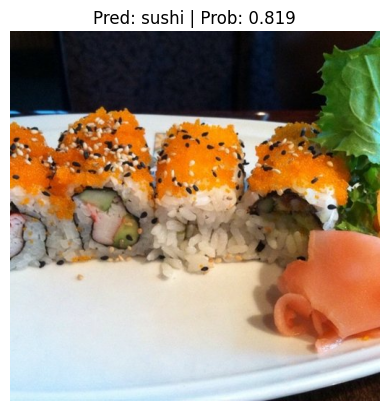

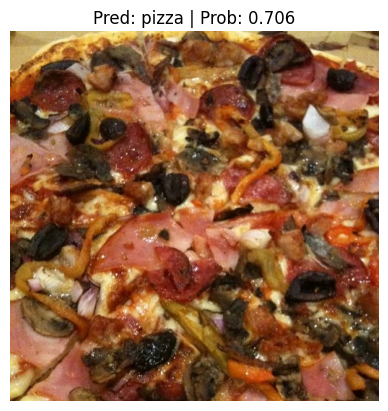

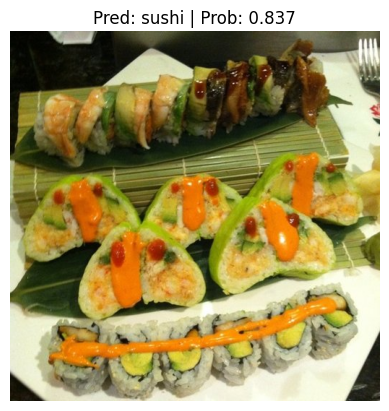

In [48]:
# Import function to make prediction in images and plot them
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 image path names from the test dataset
import random
num_images_to_plot = 3

test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,
                                      k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                       image_path=image_path,
                       class_names=class_names,
                       image_size=(224, 224))

### Predict in a suctom image with the best model.

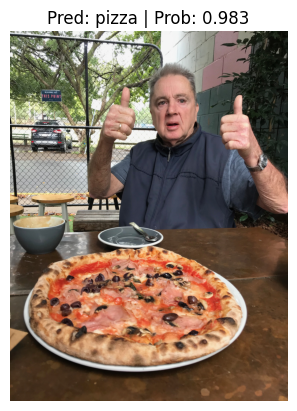

In [52]:
custom_image_path = "data/04-pizza-dad.jpeg"

pred_and_plot_image(
    model=best_model,
    image_path=custom_image_path,
    class_names=class_names
)